In [1]:
import os
import re
import json
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import tifffile
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [6]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1')
region_dir = project_dir / 'analysis' / 'region_characterization'
fig_dir = region_dir / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)
results_dir = region_dir / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

In [7]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
case_order = [
    'HT206B1',
    'HT268B1',
    'HT339B2-H1',
    'HT397B1',
    'HT565B1-H2',
    'HT704B1',
    'HT891Z1',
    'HT913Z1',
    'S18-5591-C8',
    'S18-9906',
]

In [9]:
fps = sorted(utils.listfiles(region_dir, regex=r'.txt.gz$'))

sid_to_data = {}
dtype_to_df = {}
for fp in fps:
    name = fp.split('/')[-1]
    sid = re.sub(r'^(.*)_regions.txt.gz$', r'\1', name)
    print(sid)
    case = re.sub(r'^(.*)-U[0-9]+$', r'\1', sid)

    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    config = alter_filesystem(config, source_root, target_root)

    imaris_dir = project_dir / case / 'imaris' / 'rois'
    meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))
    
    sid_to_channels = meta['sid_to_channels']
    dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
    sid_to_dtype_ident = meta['sid_to_dtype_ident']
    dti = sid_to_dtype_ident[sid]
    channels = sid_to_channels[sid]
    dtype = dtype_ident_to_dtype[dti]

    df = pd.read_csv(fp, sep='\t', index_col=0)
    df['case'] = case
    df['sid'] = sid
    df['label'] = df.index.to_list()
    df['dtype'] = dtype
    df['dtype_ident'] = dti
    df['cohort'] = 'serial'

    if case in [
        'HT891Z1',
        'HT913Z1',
        'S18-5591-C8',
        'S18-9906'
    ]:
        df['disease'] = 'prad'
    else:
        df['disease'] = 'brca'
    
    df.index = [f'{sid}_{x}' for x in df.index.to_list()]
    
    sid_to_data[sid] = {
        'df': df,
        'labeled_regions': fp.replace('_regions.txt.gz', '_regions.tif'),
        'labeled_boundaries': fp.replace('_regions.txt.gz', '_boundaries.tif'),
        'labeled_tme': fp.replace('_regions.txt.gz', '_tme.tif'),
        'channels': channels
    }

    if dtype not in dtype_to_df:
        dtype_to_df[dtype] = []
    dtype_to_df[dtype].append(df)

dtype_to_df = {k:pd.concat(v) for k, v in dtype_to_df.items()}

HT206B1-U10
HT206B1-U13
HT206B1-U16
HT206B1-U17
HT206B1-U18
HT206B1-U1
HT206B1-U21
HT206B1-U24
HT206B1-U2
HT206B1-U5
HT206B1-U8
HT206B1-U9
HT339B2-H1-U2
HT397B1-U12
HT397B1-U22
HT397B1-U2
HT397B1-U31
HT565B1-H2-U2
HT704B1-U11
HT704B1-U14
HT704B1-U17
HT704B1-U19
HT704B1-U1
HT704B1-U22
HT704B1-U26
HT704B1-U27
HT704B1-U2
HT704B1-U33
HT704B1-U35
HT704B1-U41
HT704B1-U43
HT704B1-U47
HT704B1-U50
HT704B1-U51
HT704B1-U53
HT704B1-U56
HT704B1-U60
HT704B1-U68
HT704B1-U76
HT704B1-U82
HT704B1-U85
HT704B1-U91
HT891Z1-U103
HT891Z1-U104
HT891Z1-U108
HT891Z1-U109
HT891Z1-U110
HT891Z1-U111
HT891Z1-U113
HT891Z1-U14
HT891Z1-U1
HT891Z1-U21
HT891Z1-U2
HT891Z1-U31
HT891Z1-U32
HT891Z1-U33
HT891Z1-U40
HT891Z1-U41
HT891Z1-U43
HT891Z1-U44
HT891Z1-U45
HT891Z1-U46
HT891Z1-U58
HT891Z1-U59
HT891Z1-U69
HT891Z1-U79
HT891Z1-U81
HT891Z1-U93
HT891Z1-U94
HT913Z1-U101
HT913Z1-U102
HT913Z1-U111
HT913Z1-U11
HT913Z1-U121
HT913Z1-U125
HT913Z1-U12
HT913Z1-U1
HT913Z1-U21
HT913Z1-U22
HT913Z1-U2
HT913Z1-U33
HT913Z1-U34
HT913Z1-U35


In [10]:
for dtype, df in dtype_to_df.items():
    print(dtype, df.shape)

multiplex (38841, 349)
xenium (31915, 15871)
cosmx (3460, 3139)
vishd (2341, 54262)


add in auxilary xenium

In [11]:
aux_dir = project_dir / 'xenium_aux'
fps = sorted(utils.listfiles(aux_dir, regex=r'_regions.txt.gz$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT2681-Th1H3L1U2_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT268B1-Th1H3L1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT591B1-S1H1Fp1Us1_1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT814Z1-S1H1Fp1Us1_3_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT817Z1-S1H1Fp1Us1_2_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT832Z1-S1H1Fp1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT832Z1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT849Z1-S1H2Fp1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/HT852Z1-S1H1Fp1U1_regions.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/xenium_aux/S18-11798-A15Us1_1_regions.txt.gz',
 '/data/e

In [12]:
stacked = []
for fp in fps:
    sid = fp.split('/')[-1].replace('_regions.txt.gz', '')
    print(sid)
    if sid[:2] == 'HT':
        case = sid.split('-')[0]
    else:
        case = '-'.join(sid.split('-')[:2])

    if case == 'HT2681': # one case is misnamed
        case = 'HT268B1'
    
    dtype = 'xenium'
    dti = 'xenium_0'

    channels = yaml.safe_load(open(fp.replace('_regions.txt.gz', '_metadata.yaml')))['channels']

    df = pd.read_csv(fp, sep='\t', index_col=0)
    df['case'] = case
    df['sid'] = sid
    df['label'] = df.index.to_list()
    df['dtype'] = dtype
    df['dtype_ident'] = dti
    df['cohort'] = 'singleton'

    if case in [
        'HT2681',
        'HT268B1',
        'HT591B1',
    ]:
        df['disease'] = 'brca'
    else:
        df['disease'] = 'prad'
    
    df.index = [f'{sid}_{x}' for x in df.index.to_list()]
    
    sid_to_data[sid] = {
        'df': df,
        'labeled_regions': fp.replace('_regions.txt.gz', '_regions.tif'),
        'labeled_boundaries': fp.replace('_regions.txt.gz', '_boundaries.tif'),
        'labeled_tme': fp.replace('_regions.txt.gz', '_tme.tif'),
        'channels': channels
    }
    stacked.append(df)
len(stacked)

HT2681-Th1H3L1U2
HT268B1-Th1H3L1U1
HT591B1-S1H1Fp1Us1_1
HT814Z1-S1H1Fp1Us1_3
HT817Z1-S1H1Fp1Us1_2
HT832Z1-S1H1Fp1U1
HT832Z1U1
HT849Z1-S1H2Fp1U1
HT852Z1-S1H1Fp1U1
S18-11798-A15Us1_1
S18-15142-B17Us2_1
S18-15142Fp1Us1_1
S18-18215-A25Us1_1
S18-5591-C8Us1_1
S18-8122-B28U1
S18-8795-A10Us2_1
S18-9251-F15U1
S18-9259-B14U1
S19-41530-D1U3
S20-12521-A15U1
S21-11816-A2U3
S21-44455-A1U3
S22-44238-A29U1
S22-53426-A1U3


24

In [13]:
dtype_to_df['xenium'] = pd.concat((dtype_to_df['xenium'], *stacked))

In [ ]:
for dtype, df in dtype_to_df.items():
    fp = results_dir / f'{dtype}_combined.txt'
    df.to_csv(fp, sep='\t')

In [38]:
from typing import Iterable

In [ ]:
def get_correlation_df(dtype, disease, target_channels, root='region'):
    df = dtype_to_df[dtype]
    df = df[df['disease']==disease]
    
    cols = [c for c in df.columns if f'{root}_' in c if c not in target_channels]
    data = []
    for sid in sorted(set(df['sid'])):
        source = df[df['sid']==sid]
        if 'HT206B1' in sid: # is basal cell of origin
            channel = 'boundary_sma' if dtype == 'multiplex' else 'boundary_ACTA2'
        else:
            channel = [c for c in target_channels if c in source.columns and np.count_nonzero(~pd.isnull(source[c])) > 0][0]
        print(sid, channel)

        for col in cols:
            f = source[[channel, col, 'case', 'sid']]
            m = ~pd.isnull(f[col]) & ~pd.isnull(f[channel])
            f = f[m]
            if f.shape[0]:
                xs = [x if not isinstance(x, Iterable) else x[0] for x in f[channel]]
                ys = [x if not isinstance(x, Iterable) else x[0] for x in f[col]]
                r = scipy.stats.pearsonr(xs, ys)
                
                data.append([f['case'].iloc[0], sid, channel, col, r.correlation, r.pvalue])
    corr_df = pd.DataFrame(data=data, columns=['case', 'sid', 'channel', 'feature', 'correlation', 'pvalue'])

    grouped = corr_df[['case', 'feature', 'correlation', 'pvalue']].groupby(['case', 'feature']).mean()
    grouped = grouped.reset_index()
    grouped = corr_df[['feature', 'correlation', 'pvalue']].groupby('feature').mean()
    grouped[grouped['pvalue'] < .05]
    grouped = grouped.sort_values('correlation')

    return grouped, corr_df


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=scipy.stats.ConstantInputWarning)

corr_dfs = {}
raw_corrs = {}

order = ['boundary_KRT5', 'boundary_KRT7', 'boundary_KRT14', 'boundary_TP63', 'boundary_ACTA2']
channel_mappings = {
    'xenium': order,
    'cosmx': order,
    'vishd': order,
    'multiplex': ['boundary_ck5', 'boundary_ck7', 'boundary_ck14', 'boundary_sma']
}

roots = ['region', 'boundary', 'tme']
for dtype in dtype_to_df.keys():
    for disease in ['brca', 'prad']:
        for root in roots:
            key = f'{disease}_{dtype}_{root}'
            
            print(key)
            df, corrs = get_correlation_df(dtype, disease, channel_mappings[dtype], root=root)
            corr_dfs[key] = df
            raw_corrs[key] = corrs

            df.to_csv(results_dir / f'{key}_correlations.txt', sep='\t')
            corrs.to_csv(results_dir / f'{key}_correlations_raw.txt', sep='\t')

In [ ]:
# corr_dfs = {}
# raw_corrs = {}

# fps = sorted(utils.listfiles(results_dir, regex=r'_correlations.txt$'))
# for fp in fps:
#     key = fp.split('/')[-1].replace('_correlations.txt', '')
#     corr_dfs[key] = pd.read_csv(fp, sep='\t')
#     raw_corrs[key] = pd.read_csv(fp.replace('_correlations_raw.txt', ''), sep='\t')    

In [167]:
corr_dfs.keys()

dict_keys(['brca_multiplex_region', 'brca_multiplex_boundary', 'brca_multiplex_tme', 'prad_multiplex_region', 'prad_multiplex_boundary', 'prad_multiplex_tme', 'brca_xenium_region', 'brca_xenium_boundary', 'brca_xenium_tme', 'prad_xenium_region', 'prad_xenium_boundary', 'prad_xenium_tme', 'brca_cosmx_region', 'brca_cosmx_boundary', 'brca_cosmx_tme', 'prad_cosmx_region', 'prad_cosmx_boundary', 'prad_cosmx_tme', 'brca_vishd_region', 'brca_vishd_boundary', 'brca_vishd_tme', 'prad_vishd_region', 'prad_vishd_boundary', 'prad_vishd_tme'])

In [1041]:
def get_corrs_sources(corr_dfs, exclude=('celltypes', 'nbhd', 'myoepithelial', 'epithelial'), include=None):
    diseases = ['brca', 'prad']
    dtypes = ['xenium', 'cosmx', 'vishd']
    idents = ['region', 'tme']
    tups = [(ident, dtype) for ident in idents for dtype in dtypes]
    to_corr_sources = {}
    for i, disease in enumerate(diseases):
        to_corr_sources[disease] = {}
        for j, dtype in enumerate(dtypes):
            to_corr_sources[disease][dtype] = {}
            for k, ident in enumerate(idents):
                df = corr_dfs[f'{disease}_{dtype}_{ident}']
                
                if exclude is not None:
                    idxs = [i for i in df.index.to_list() if not len([x for x in exclude if x in i])]
                elif include is not None:
                    idxs = [i for i in df.index.to_list() if len([x for x in include if x in i])]
                else:
                    raise RuntimeError('specify exclude or include')
                
                source = df.loc[idxs]
                source = source[~pd.isnull(source['correlation'])]
                if source.shape[0]:
                    source = source.sort_values('correlation', ascending=False)
                    source.index = [c.replace(f'region_', '').replace('tme_', '') for c in source.index.to_list()]
    
                    to_corr_sources[disease][dtype][ident] = source
    return to_corr_sources

In [1044]:
to_gene_corr_sources = get_corrs_sources(corr_dfs)
to_ct_corr_sources = get_corrs_sources(corr_dfs, exclude=None, include=('celltypes',))

In [1052]:
a = to_gene_corr_sources['prad']['xenium']['tme']
b = to_gene_corr_sources['prad']['xenium']['region']

In [1056]:
for j, i in enumerate(b.index.to_list()):
    print(i, j, a.index.to_list().index(i))

KRT5 0 0
CYP4B1 1 3
DST 2 11
KRT15 3 1
NTN4 4 8
TP63 5 2
KRT14 6 6
KRT17 7 4
FHL2 8 38
KRT19 9 5
COL17A1 10 10
KRT7 11 15
C3 12 100
EGFR 13 32
GATA3 14 23
VWA5A 15 110
PDPN 16 50
GJA1 17 42
LAMB3 18 9
TENT5C 19 61
LTBP2 20 78
S100P 21 35
MET 22 31
ITGB4 23 22
TNC 24 87
CPA6 25 13
FAT2 26 7
ROBO1 27 20
PIGR 28 29
APOBEC3C 29 85
IRAK3 30 144
CYP3A5 31 14
ID3 32 158
MMP14 33 129
CD74 34 172
AMY2B 35 71
IRX5 36 18
BCL11A 37 30
ANO1 38 227
NOTCH1 39 63
ITGB6 40 17
DUOXA1 41 16
KCNJ15 42 28
GATM 43 353
SOX2 44 39
MEIS2 45 56
P2RY2 46 25
MECOM 47 133
MYOF 48 53
SNAI2 49 92
LURAP1 50 47
NOS1 51 44
LTF 52 37
KLK11 53 89
PTPRZ1 54 43
FLRT3 55 34
NAV2 56 98
COL7A1 57 68
FAS 58 146
LAMA3 59 119
S1PR5 60 70
GPX2 61 48
CDH13 62 373
EHF 63 720
HOXD10 64 41
MDM2 65 187
CLCA2 66 62
CCL2 67 777
EDN1 68 153
VAV3 69 82
LAMC2 70 33
GPRC5A 71 57
CYP27A1 72 107
NLRP1 73 292
GAS6 74 376
PROM1 75 193
TMEM173 76 109
SLC2A1 77 132
DUOX2 78 24
CD40 79 139
GABRP 80 12
ANXA8 81 26
AMY2A 82 150
SCGB1A1 83 4145
SPATA

In [1050]:
from matplotlib import colors
def plot_corrs(to_corr_sources, n=20, cmap='PiYG'):
    diseases = ['brca', 'prad']
    dtypes = ['xenium', 'cosmx', 'vishd']
    idents = ['region', 'tme']
    
    tups = [(ident, dtype) for ident in idents for dtype in dtypes]
    fig, axs = plt.subplots(nrows=len(diseases) * len(dtypes) * len(idents) // 2, ncols=2)
    for i, disease in enumerate(diseases):
        for j, dtype in enumerate(dtypes):
            for k, ident in enumerate(idents):
                ax = axs[tups.index((ident, dtype)), i]
                source = to_corr_sources[disease][dtype].get(ident)
                if source is not None and source.shape[0]:
                    if n * 2 < source.shape[0]:
                        source = pd.concat((source.iloc[:n], source.iloc[-n:]))
                    source = source.sort_values('correlation', ascending=False)
                    source.index = [c.replace(f'region_', '').replace('tme_', '') for c in source.index.to_list()]
            
                    divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
                    
                    sns.heatmap(source[['correlation']].T, cmap=cmap, norm=divnorm, xticklabels=True, ax=ax)
        
                    ax.set_ylabel(f'{disease}_{dtype}_{ident}', rotation=90)
                    ax.set_xlabel('')
                    ax.set_yticks([])
    
                    for x in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
                        x.set_fontsize(2)
                    ax.tick_params(length=0)
                else:
                    ax.axis('off')
                

In [1048]:
fig_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/analysis/region_characterization/figures')

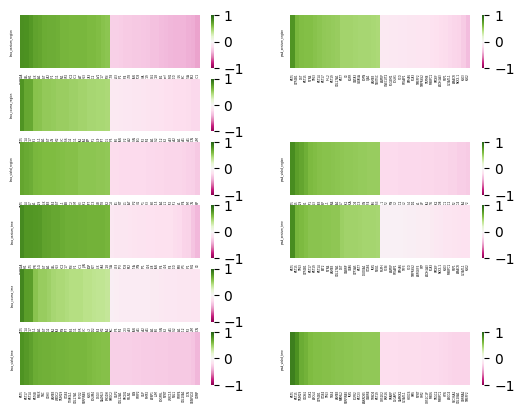

In [1049]:
plot_corrs(to_gene_corr_sources, n=20)
plt.savefig(fig_dir / f'region_basal_gene_corrs.svg')

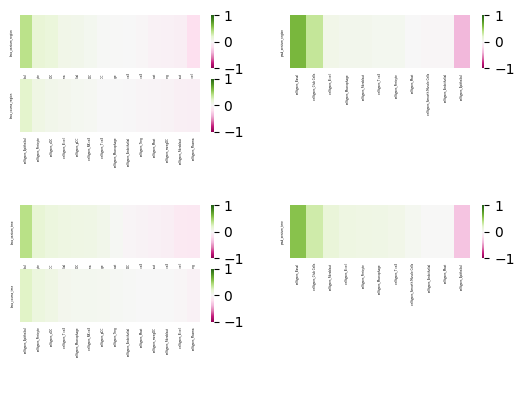

In [1051]:
plot_corrs(to_ct_corr_sources, n=20)
plt.savefig(fig_dir / f'region_basal_celltype_corrs.svg')

In [172]:
for k, v in raw_corrs.items():
    disease, dtype, root = k.split('_')

    if dtype == 'xenium':
        v['dtype_ident'] = ['xenium' if len(sid_to_data[sid]['channels']) < 2000 else 'xenium5k' for sid in v['sid']]
    else:
        v['dtype_ident'] = dtype
    raw_corrs[k] = v

In [418]:
dti_to_sids = {
    'brca': {},
    'prad': {},
}
dti_to_cases = {
    'brca': {},
    'prad': {},
}
for sid, data in sid_to_data.items():
    dtype = data['df'].iloc[0]['dtype']
    case = data['df'].iloc[0]['case']
    disease = data['df'].iloc[0]['disease']
    if len(data['channels']) > 2000 and dtype == 'xenium':
        dti = 'xenium5k'
    else:
        dti = dtype

    if dti not in dti_to_sids[disease]:
        dti_to_sids[disease][dti] = set()
        dti_to_cases[disease][dti] = set()
    
    dti_to_sids[disease][dti].add(sid)
    dti_to_cases[disease][dti].add(case)

    if dti == 'xenium5k':
        dti_to_sids[disease]['xenium'].add(sid)
        dti_to_cases[disease]['xenium'].add(case)


In [419]:
dti_to_sids

{'brca': {'multiplex': {'HT206B1-U10',
   'HT206B1-U13',
   'HT206B1-U18',
   'HT206B1-U2',
   'HT206B1-U21',
   'HT206B1-U5',
   'HT339B2-H1-U2',
   'HT397B1-U12',
   'HT397B1-U2',
   'HT397B1-U22',
   'HT397B1-U31',
   'HT565B1-H2-U2',
   'HT704B1-U11',
   'HT704B1-U19',
   'HT704B1-U27',
   'HT704B1-U35',
   'HT704B1-U43',
   'HT704B1-U53',
   'HT704B1-U60',
   'HT704B1-U68',
   'HT704B1-U76',
   'HT704B1-U82',
   'HT704B1-U85',
   'HT704B1-U91'},
  'xenium': {'HT206B1-U1',
   'HT206B1-U16',
   'HT206B1-U17',
   'HT206B1-U24',
   'HT206B1-U8',
   'HT206B1-U9',
   'HT2681-Th1H3L1U2',
   'HT268B1-Th1H3L1U1',
   'HT591B1-S1H1Fp1Us1_1',
   'HT704B1-U1',
   'HT704B1-U17',
   'HT704B1-U26',
   'HT704B1-U33',
   'HT704B1-U41',
   'HT704B1-U50'},
  'cosmx': {'HT704B1-U14', 'HT704B1-U22', 'HT704B1-U47', 'HT704B1-U56'},
  'vishd': {'HT704B1-U2', 'HT704B1-U51'}},
 'prad': {'multiplex': {'HT891Z1-U103',
   'HT891Z1-U108',
   'HT891Z1-U109',
   'HT891Z1-U110',
   'HT891Z1-U111',
   'HT891Z1-U113

In [178]:
# df = raw_corrs['prad_xenium_region'].copy()
# df = df[df['dtype_ident']=='xenium5k']
# df

In [180]:
# from collections import Counter
# Counter(df['feature']).most_common()

In [1008]:
dti_to_cut = {
    'xenium': .2,
    'xenium5k': .2,
    'cosmx': .2,
    'vishd': .2,
    'multiplex': .2
}

In [379]:
pval_cut = .05
root = 'region'

data = []
for key, df in raw_corrs.items():
    print(key)
    disease, dtype, root = key.split('_')
    feats = sorted(set([x for x in df['feature']]))
    feats = [x for x in feats if root in x]

    for feat in feats:
        small = df[df['feature'] == feat]
        val = small['correlation'].mean()

        m = (small['correlation'].abs() > dti_to_cut[dtype]) & (small['pvalue'] < pval_cut)
        small = small[m]
        sid_count = len(set(small['sid']))
        case_count = len(set(small['case']))
        
        direction = 'positive' if val > 0 else 'negative'
        data.append([disease, dtype, root, feat, sid_count, case_count, val, abs(val), direction])


        if dtype == 'xenium':
            small = df[df['feature'] == feat]
            small = small[small['dtype_ident'] == 'xenium5k']
            val = small['correlation'].mean()
    
            m = (small['correlation'].abs() > dti_to_cut['xenium5k']) & (small['pvalue'] < pval_cut)
            small = small[m]
            sid_count = len(set(small['sid']))
            case_count = len(set(small['case']))
            
            direction = 'positive' if val > 0 else 'negative'
            data.append([disease, 'xenium5k', root, feat, sid_count, case_count, val, abs(val), direction])
        
count_df = pd.DataFrame(data=data, columns=['disease', 'dtype', 'type', 'feature', 'sid_count', 'case_count', 'correlation', 'correlation_abs', 'direction'])
count_df


brca_multiplex_region
brca_multiplex_boundary
brca_multiplex_tme
prad_multiplex_region
prad_multiplex_boundary
prad_multiplex_tme
brca_xenium_region
brca_xenium_boundary
brca_xenium_tme
prad_xenium_region
prad_xenium_boundary
prad_xenium_tme
brca_cosmx_region
brca_cosmx_boundary
brca_cosmx_tme
prad_cosmx_region
prad_cosmx_boundary
prad_cosmx_tme
brca_vishd_region
brca_vishd_boundary
brca_vishd_tme
prad_vishd_region
prad_vishd_boundary
prad_vishd_tme


,disease,dtype,type,feature,sid_count,case_count,correlation,correlation_abs,direction
0,brca,multiplex,region,region_a-amylase,1,1,-0.078797,0.078797,negative
1,brca,multiplex,region,region_bap1,1,1,-0.052376,0.052376,negative
2,brca,multiplex,region,region_bca1,0,0,-0.005021,0.005021,negative
3,brca,multiplex,region,region_cd11b,14,3,0.246429,0.246429,positive
4,brca,multiplex,region,region_cd163,9,2,0.067867,0.067867,positive
...,...,...,...,...,...,...,...,...,...
149602,prad,vishd,tme,tme_ZXDC,1,1,0.139415,0.139415,positive
149603,prad,vishd,tme,tme_ZYG11A,1,1,0.252774,0.252774,positive
149604,prad,vishd,tme,tme_ZYG11B,0,0,0.028538,0.028538,positive
149605,prad,vishd,tme,tme_ZYX,1,1,0.288726,0.288726,positive


In [380]:
fp = results_dir / 'counts_support.txt'
count_df.to_csv(fp, sep='\t', index=False)

In [409]:
root = 'region'
to_source = {}
for disease in ['brca', 'prad']:
    for dtype in set(count_df['dtype']):
        m = (count_df['disease']==disease) & (count_df['dtype']==dtype) & (count_df['type']==root)
        f = count_df[m]
        
        exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
        idxs = [i for i, val in zip(f.index.to_list(), f['feature']) if not len([x for x in exclude if x in val])]
        f = f.loc[idxs]
        f = f[~pd.isnull(f['correlation'])]
        f = f.sort_values(['case_count', 'sid_count', 'correlation_abs'], ascending=False)
        print(f.shape)

        for direction in ['positive', 'negative']:
            x = f[f['direction']==direction]
            print(disease, dtype, x.shape)
            x.to_csv(results_dir / f'counts_support_{disease}_{dtype}_{direction}.txt', sep='\t', index=False)

            if disease not in to_source:
                to_source[disease] = {}
            if dtype not in to_source[disease]:
                to_source[disease][dtype] = {}
            to_source[disease][dtype][direction] = x


(44, 9)
brca multiplex (36, 9)
brca multiplex (8, 9)
(0, 9)
brca xenium5k (0, 9)
brca xenium5k (0, 9)
(1000, 9)
brca cosmx (899, 9)
brca cosmx (101, 9)
(18047, 9)
brca vishd (12642, 9)
brca vishd (5405, 9)
(747, 9)
brca xenium (406, 9)
brca xenium (341, 9)
(26, 9)
prad multiplex (24, 9)
prad multiplex (2, 9)
(5101, 9)
prad xenium5k (4225, 9)
prad xenium5k (876, 9)
(0, 9)
prad cosmx (0, 9)
prad cosmx (0, 9)
(18065, 9)
prad vishd (12718, 9)
prad vishd (5347, 9)
(5392, 9)
prad xenium (4486, 9)
prad xenium (906, 9)


In [1010]:
dti_to_cmap = {
    'xenium': 'oranges',
    'xenium5k': 'teals',
    'cosmx': 'browns',
    'vishd': 'cividis',
    'multiplex': 'greens'
}


def generate_subchart(df, key, vmax, cmap='oranges'):
    df['x'] = key
    a = alt.Chart(df).mark_circle(size=250).encode(
        x=alt.X('x'),
        y=alt.Y('feature', sort=df['feature'].to_list()),
        color=alt.Color(key, scale=alt.Scale(scheme=cmap, domain=[0, vmax]))
    )
    
    b = alt.Chart(df).mark_text(baseline="middle", color='white').encode(
        x=alt.X('x'),
        y=alt.Y('feature', sort=df['feature'].to_list()),
        text=alt.Text(key)
    )
    
    return a + b

def generate_chart_row(source, disease, dti):
    max_cases = len(dti_to_cases[disease][dti])
    max_sids = len(dti_to_sids[disease][dti])
    print(max_cases, max_sids)
    
    cs = []
    for k in ['sid_count', 'case_count']:
        cs.append(generate_subchart(source,
                                    k,
                                    vmax=max_cases if k == 'case_count' else max_sids,
                                    cmap=dti_to_cmap[dti]))
    
    f = source
    f['x'] = 'correlation'
    a = alt.Chart(f, title=f'{disease}_{dti}').mark_rect().encode(
        x=alt.X('x'),
        y=alt.Y('feature', sort=f['feature'].to_list()),
        color=alt.Color('correlation', scale=alt.Scale(scheme="pinkyellowgreen", domain=[-1, 1], reverse=False))
    )
    cs.append(a)
    
    return alt.hconcat(*cs).resolve_scale(color='independent')

In [1011]:
n = 20
s = None
charts = []
gene_dict = {}
for disease, d1 in to_source.items():
    if disease not in gene_dict:
        gene_dict[disease] = {}
    for dti, d2 in d1.items():
        if dti not in gene_dict[disease]:
            gene_dict[disease][dti] = {}
        for direction, source in d2.items():
            print(disease, dti, source.shape)
            
            if source.shape[0]:
                s = source.iloc[:n].copy()
                s['feature'] = [x.replace('region_', '') for x in s['feature']]
                charts.append(generate_chart_row(s, disease, dti))
                gene_dict[disease][dti][direction] = s['feature'].to_list()
                
            else:
                print(f'{disease} {dti} is missing')
                

alt.vconcat(*charts).resolve_scale(color='independent', x='independent', y='independent')

brca multiplex (36, 9)
5 24
brca multiplex (8, 9)
5 24
brca xenium5k (0, 9)
brca xenium5k is missing
brca xenium5k (0, 9)
brca xenium5k is missing
brca cosmx (899, 9)
1 4
brca cosmx (101, 9)
1 4
brca vishd (12642, 9)
1 2
brca vishd (5405, 9)
1 2
brca xenium (406, 9)
4 15
brca xenium (341, 9)
4 15
prad multiplex (24, 9)
4 42
prad multiplex (2, 9)
4 42
prad xenium5k (4225, 9)
3 5
prad xenium5k (876, 9)
3 5
prad cosmx (0, 9)
prad cosmx is missing
prad cosmx (0, 9)
prad cosmx is missing
prad vishd (12718, 9)
1 2
prad vishd (5347, 9)
1 2
prad xenium (4486, 9)
25 49
prad xenium (906, 9)
25 49


alt.VConcatChart(...)

In [816]:
dti_to_sid_order = {}
for disease, d1 in dti_to_sids.items():
    if disease not in dti_to_sid_order:
        dti_to_sid_order[disease] = {}
    for dti, sids in d1.items():
        tups = []
        for sid in sids:
            x1 = re.sub(r'^(.*)[-_]U([0-9]+)$', r'\1', sid)
            x2 = re.sub(r'^.*U([0-9]+)$', r'\1', sid)
            try:
                x2 = int(x2)
            except:
                pass
            tups.append((x1, x2, sid))
        tups = sorted(tups)
        sids = [sid for _, _, sid in tups]
        dti_to_sid_order[disease][dti] = sids

sid_order = []
for disease in ['brca', 'prad']:
    for dti in ['xenium', 'xenium5k', 'cosmx', 'vishd']:
        sid_order += [x for x in dti_to_sid_order[disease].get(dti, [])
                      if not (dti == 'xenium' and x in dti_to_sids['prad']['xenium5k'])]
sid_order

['HT206B1-U1',
 'HT206B1-U8',
 'HT206B1-U9',
 'HT206B1-U16',
 'HT206B1-U17',
 'HT206B1-U24',
 'HT2681-Th1H3L1U2',
 'HT268B1-Th1H3L1U1',
 'HT591B1-S1H1Fp1Us1_1',
 'HT704B1-U1',
 'HT704B1-U17',
 'HT704B1-U26',
 'HT704B1-U33',
 'HT704B1-U41',
 'HT704B1-U50',
 'HT704B1-U14',
 'HT704B1-U22',
 'HT704B1-U47',
 'HT704B1-U56',
 'HT704B1-U2',
 'HT704B1-U51',
 'HT814Z1-S1H1Fp1Us1_3',
 'HT817Z1-S1H1Fp1Us1_2',
 'HT832Z1-S1H1Fp1U1',
 'HT849Z1-S1H2Fp1U1',
 'HT852Z1-S1H1Fp1U1',
 'HT891Z1-U1',
 'HT891Z1-U21',
 'HT891Z1-U31',
 'HT891Z1-U44',
 'HT891Z1-U59',
 'HT891Z1-U69',
 'HT891Z1-U81',
 'HT891Z1-U94',
 'HT891Z1-U104',
 'HT913Z1-U33',
 'HT913Z1-U34',
 'HT913Z1-U35',
 'HT913Z1-U61',
 'HT913Z1-U81',
 'HT913Z1-U101',
 'S18-11798-A15Us1_1',
 'S18-15142-B17Us2_1',
 'S18-15142Fp1Us1_1',
 'S18-18215-A25Us1_1',
 'S18-5591-C8-U1',
 'S18-5591-C8-U5',
 'S18-5591-C8-U7',
 'S18-5591-C8-U12',
 'S18-5591-C8-U18',
 'S18-5591-C8-U20',
 'S18-5591-C8Us1_1',
 'S18-8795-A10Us2_1',
 'S18-9251-F15U1',
 'S18-9259-B14U1',
 'S

In [769]:
dti_to_sid_order

{'brca': {'multiplex': ['HT206B1-U2',
   'HT206B1-U5',
   'HT206B1-U10',
   'HT206B1-U13',
   'HT206B1-U18',
   'HT206B1-U21',
   'HT339B2-H1-U2',
   'HT397B1-U2',
   'HT397B1-U12',
   'HT397B1-U22',
   'HT397B1-U31',
   'HT565B1-H2-U2',
   'HT704B1-U11',
   'HT704B1-U19',
   'HT704B1-U27',
   'HT704B1-U35',
   'HT704B1-U43',
   'HT704B1-U53',
   'HT704B1-U60',
   'HT704B1-U68',
   'HT704B1-U76',
   'HT704B1-U82',
   'HT704B1-U85',
   'HT704B1-U91'],
  'xenium': ['HT206B1-U1',
   'HT206B1-U8',
   'HT206B1-U9',
   'HT206B1-U16',
   'HT206B1-U17',
   'HT206B1-U24',
   'HT2681-Th1H3L1U2',
   'HT268B1-Th1H3L1U1',
   'HT591B1-S1H1Fp1Us1_1',
   'HT704B1-U1',
   'HT704B1-U17',
   'HT704B1-U26',
   'HT704B1-U33',
   'HT704B1-U41',
   'HT704B1-U50'],
  'cosmx': ['HT704B1-U14', 'HT704B1-U22', 'HT704B1-U47', 'HT704B1-U56'],
  'vishd': ['HT704B1-U2', 'HT704B1-U51']},
 'prad': {'multiplex': ['HT891Z1-U14',
   'HT891Z1-U32',
   'HT891Z1-U40',
   'HT891Z1-U41',
   'HT891Z1-U43',
   'HT891Z1-U45',
   

In [897]:
to_gene_corr_sources = {}
for disease, d1 in gene_dict.items():
    to_gene_corr_sources[disease] = {}
    for dti, d2 in d1.items():
        dtype = dti.replace('5k', '')
        f = raw_corrs[f'{disease}_{dtype}_region'].copy()
        f = f[f['dtype_ident']==dti]
        f.index = [x.replace('region_', '') + '_' + y  for x, y in f[['feature', 'sid']].values]
        assert len(set(f.index.to_list())) == f.shape[0]
        for direction, feats in d2.items():
            if dti in dti_to_sids[disease]:
                data = []
                for feat in feats:
                    for sid in dti_to_sid_order[disease][dti]:
                        if f'{feat}_{sid}' in f.index:
                            val = f.loc[f'{feat}_{sid}', 'correlation']
                        else:
                            val = np.nan
                        data.append([feat, sid, val])
                source = pd.DataFrame(data=data, columns=['feature', 'sid', 'correlation'])
                source = source.pivot(columns='sid', index='feature')
                source.columns = [x for _, x in source.columns]
                source = source[dti_to_sid_order[disease][dti]]
                source = source.loc[feats]

                if dti not in to_gene_corr_sources[disease]:
                    to_gene_corr_sources[disease][dti] = {}
                to_gene_corr_sources[disease][dti][direction] = source

                source.to_csv(results_dir / f'corr_by_sid_{disease}_{dti}_{direction}.txt', sep='\t')
                
            

In [898]:
source = to_gene_corr_sources['prad']['xenium']['positive']
source

,HT814Z1-S1H1Fp1Us1_3,HT817Z1-S1H1Fp1Us1_2,HT832Z1-S1H1Fp1U1,HT832Z1U1,HT849Z1-S1H2Fp1U1,HT852Z1-S1H1Fp1U1,HT891Z1-U1,HT891Z1-U21,HT891Z1-U31,HT891Z1-U44,...,S18-9906-U2,S18-9906-U9,S18-9906-U17,S18-9906-U24,S19-41530-D1U3,S20-12521-A15U1,S21-11816-A2U3,S21-44455-A1U3,S22-44238-A29U1,S22-53426-A1U3
feature,,,,,,,,,,,,,,,,,,,,,
DST,0.762579,0.662794,0.781204,NaN,0.342477,0.777932,0.821228,0.741759,0.711746,0.745641,...,0.653305,0.658775,0.663406,0.607098,-0.454907,0.667677,0.309228,0.059822,0.660069,-0.043003
KRT5,0.817442,0.834047,0.967533,NaN,0.497655,0.828977,0.886895,0.819665,0.829581,0.852333,...,NaN,NaN,NaN,NaN,0.583523,0.758680,0.870888,0.013747,0.835012,0.841680
NTN4,0.805464,0.566718,0.842487,NaN,0.350047,0.613970,0.794804,0.761418,0.773933,0.752805,...,0.643654,0.690250,0.621192,0.652405,0.557281,0.645166,0.635798,0.033254,0.623725,0.047626
FHL2,0.798759,0.477091,0.760759,NaN,0.269842,0.623126,0.721813,0.690622,0.701112,0.637680,...,0.616720,0.760604,0.623821,0.592201,0.152556,0.642017,0.558089,0.050401,0.068714,0.251638
COL17A1,0.915080,0.169770,0.659546,NaN,0.216119,0.384244,0.578047,0.578059,0.642638,0.544832,...,0.556710,0.571253,0.525428,0.447595,0.591081,0.534550,0.784693,0.052547,0.549413,0.117040
EGFR,0.711118,0.618834,0.505282,NaN,0.235991,0.649496,0.698325,0.581714,0.465854,0.475684,...,0.506353,0.497855,0.468150,0.447835,0.221240,0.477418,0.396573,0.070763,0.674851,-0.072610
CYP4B1,0.769970,0.688756,0.812446,NaN,0.186148,0.720961,0.748472,0.715433,0.790226,0.836115,...,0.572774,0.474477,0.341522,0.415510,0.417882,0.499698,0.808338,0.032669,0.708904,-0.017618
PDPN,0.514103,0.213686,0.604905,NaN,0.171533,0.296367,0.818819,0.747171,0.711222,0.705171,...,0.482325,0.473482,0.477895,0.458002,0.463873,0.718962,0.034601,0.012173,0.631007,-0.010622
TENT5C,0.645059,0.526046,0.698799,NaN,0.180487,0.475814,0.672887,0.617864,0.504520,0.588255,...,0.520172,0.658675,0.511543,0.559553,0.422795,0.221155,0.182422,-0.090909,0.636073,-0.065484


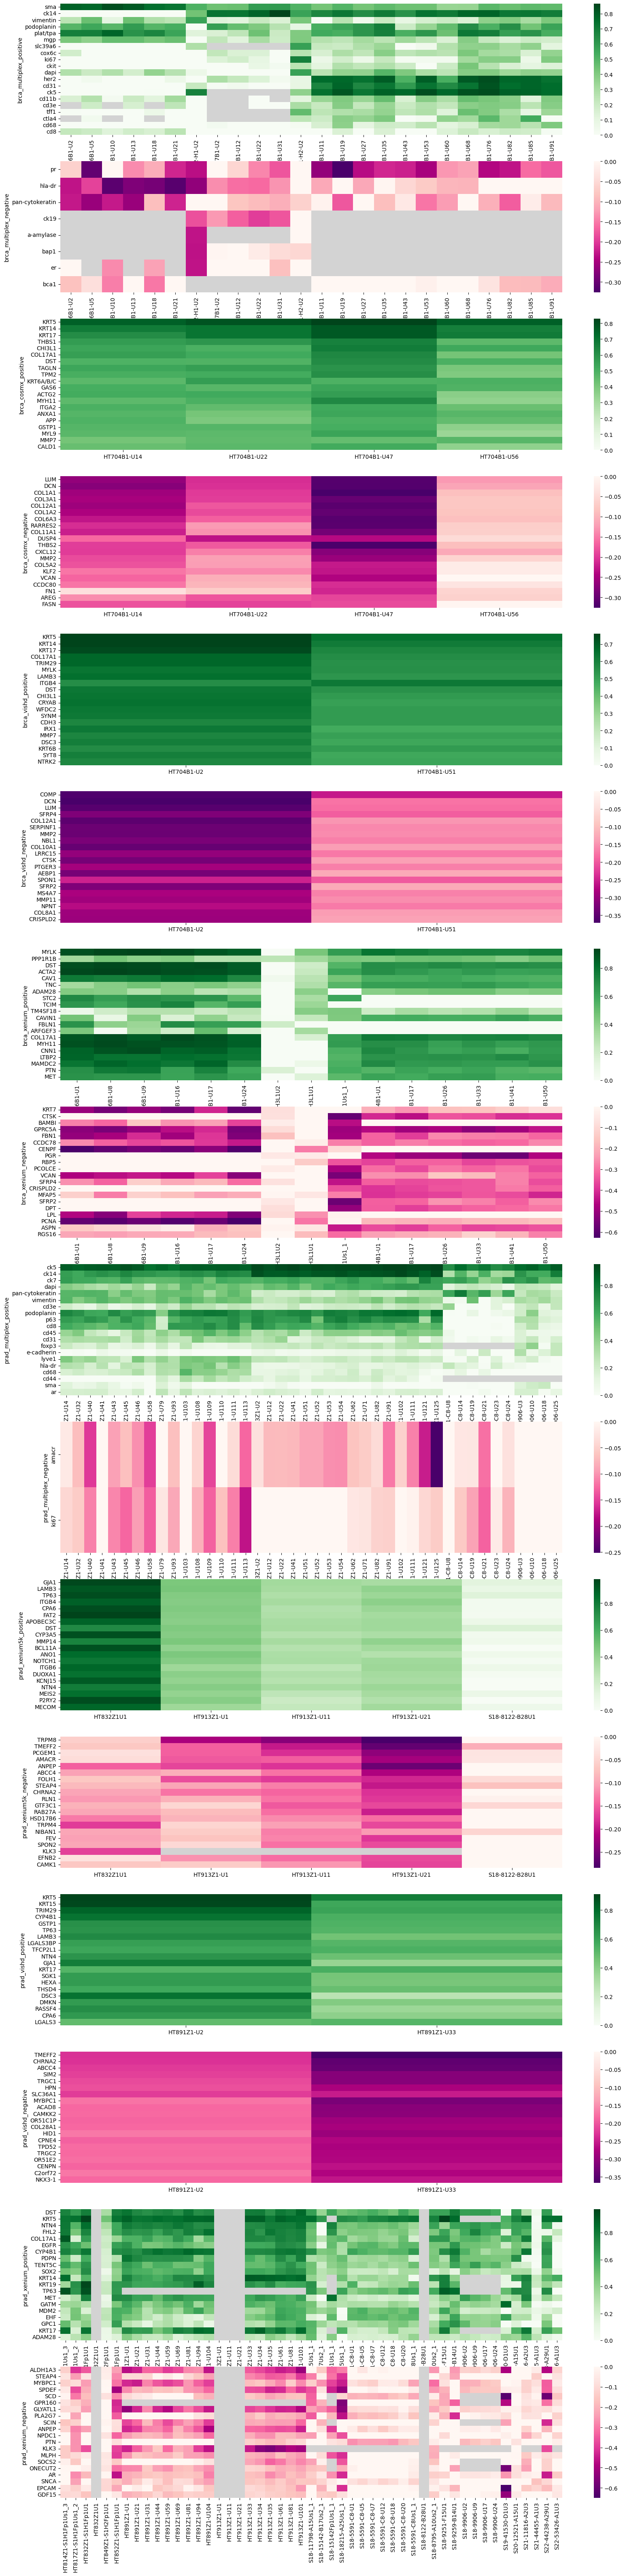

In [1013]:
fig, axs = plt.subplots(nrows=16, figsize=(20, 80))
i = 0
for disease, d1 in to_gene_corr_sources.items():
    for dti, d2 in d1.items():
        for direction, source in d2.items():
            ax = axs[i]
            if direction == 'positive':
                X = source.values.copy()
                X[pd.isnull(X)] = 0
                vmin = 0
                vmax = X.max()
                cmap = 'Greens'
            else:
                X = source.values.copy()
                X[pd.isnull(X)] = 0
                vmin = X.min()
                vmax = 0
                cmap = 'RdPu_r'
            sns.heatmap(source, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
            ax.set_ylabel(f'{disease}_{dti}_{direction}')
            ax.set_facecolor('lightgray')
            i += 1
plt.savefig(fig_dir / f'dti_specific_correlation_heatmaps.svg')

In [653]:
denoms = {}
for disease, d1 in dti_to_sids.items():
    for dti, sids in d1.items():
        if dti != 'multiplex':
            counts = []
            for sid in sids:
                channels = sorted(set(sid_to_data[sid]['channels']))
                counts.append(len(channels))
            denoms[dti] = int(np.max(counts))
denoms

{'xenium': 5101, 'cosmx': 1000, 'vishd': 18085, 'xenium5k': 5101}

In [654]:
dti_to_all_channels = {}
for dti in ['xenium', 'xenium5k', 'cosmx', 'vishd']:
    channels = sorted(set.union(*[set(sid_to_data[sid]['channels'])
                         for disease, d1 in dti_to_sids.items()
                         for sid in d1.get(dti, [])]))
    dti_to_all_channels[dti] = channels
    print(dti, len(channels))

xenium 5471
xenium5k 5101
cosmx 1000
vishd 18085


In [655]:

data = []
for disease, d1 in to_source.items():
    for dti, d2 in d1.items():
        for direction, df in d2.items():
            df = df.set_index('feature')
            df.index = [x.replace('region_', '') for x in df.index]
            for feat, row in df.iterrows():
                if dti == 'multiplex':
                    pass
                else:
                    data.append([
                        disease,
                        dti,
                        feat,
                        row['sid_count'],
                        row['case_count'],
                        row['correlation'],
                        row['correlation_abs'],
                        row['direction'],
                        df.index.to_list().index(feat),
                        df.index.to_list().index(feat) / denoms[dti]
                    ])
df = pd.DataFrame(data=data, columns=['disease', 'dtype_ident', 'feature', 'sid_count', 'case_count', 'correlation', 'correlation_abs', 'direction', 'rank', 'rank_pct'])
df = df[df['dtype_ident']!='multiplex']
df.index = [f'{x}_{y}_{z}_{zz}' for x, y, z, zz in df[['disease', 'dtype_ident', 'feature', 'direction']].values]
df


,disease,dtype_ident,feature,sid_count,case_count,correlation,correlation_abs,direction,rank,rank_pct
brca_cosmx_KRT5_positive,brca,cosmx,KRT5,4,1,0.781860,0.781860,positive,0,0.000000
brca_cosmx_KRT14_positive,brca,cosmx,KRT14,4,1,0.702561,0.702561,positive,1,0.001000
brca_cosmx_KRT17_positive,brca,cosmx,KRT17,4,1,0.690794,0.690794,positive,2,0.002000
brca_cosmx_THBS1_positive,brca,cosmx,THBS1,4,1,0.566148,0.566148,positive,3,0.003000
brca_cosmx_CHI3L1_positive,brca,cosmx,CHI3L1,4,1,0.557241,0.557241,positive,4,0.004000
...,...,...,...,...,...,...,...,...,...,...
prad_xenium_TACR1_negative,prad,xenium,TACR1,0,0,-0.000071,0.000071,negative,901,0.176632
prad_xenium_NYX_negative,prad,xenium,NYX,0,0,-0.000051,0.000051,negative,902,0.176828
prad_xenium_SND1_negative,prad,xenium,SND1,0,0,-0.000044,0.000044,negative,903,0.177024
prad_xenium_IL17F_negative,prad,xenium,IL17F,0,0,-0.000011,0.000011,negative,904,0.177220


In [656]:
# df[df['feature']=='KRT5']

In [657]:
# grouped[grouped['feature']=='KRT5']

In [658]:
# grouped_counts[grouped_counts['feature']=='KRT5']

In [659]:
grouped = df[['disease', 'feature', 'correlation', 'rank', 'rank_pct', 'direction']].groupby(
    ['disease', 'feature', 'direction']).mean()
grouped = grouped.reset_index()
grouped

,disease,feature,direction,correlation,rank,rank_pct
0,brca,A1CF,positive,0.094974,3071.000000,0.169809
1,brca,A2M,positive,0.490572,36.000000,0.001991
2,brca,A2ML1,positive,0.064113,5108.000000,0.282444
3,brca,A3GALT2,positive,0.042556,7241.000000,0.400387
4,brca,A4GALT,positive,0.106730,2583.000000,0.142826
...,...,...,...,...,...,...
38313,prad,ZYG11A,positive,0.016238,11009.000000,0.608737
38314,prad,ZYG11B,positive,0.017949,6090.000000,0.664258
38315,prad,ZYX,positive,0.223644,533.666667,0.064461
38316,prad,ZZEF1,positive,0.030487,9753.000000,0.539287


In [660]:
grouped_counts = df[['disease', 'feature', 'correlation', 'direction']].groupby(
    ['disease', 'feature', 'direction']).count()
grouped['count'] = grouped_counts['correlation'].to_list()
for dti in ['xenium', 'xenium5k', 'cosmx', 'vishd']:
    for col in ['rank', 'sid_count', 'case_count', 'correlation']:
        grouped[f'{dti}_{col}'] = [df.loc[f'{x}_{dti}_{y}_{z}', col] if f'{x}_{dti}_{y}_{z}' in df.index else np.nan
                                  for x, y, z in grouped[['disease', 'feature', 'direction']].values]
grouped

,disease,feature,direction,correlation,rank,rank_pct,count,xenium_rank,xenium_sid_count,xenium_case_count,...,xenium5k_case_count,xenium5k_correlation,cosmx_rank,cosmx_sid_count,cosmx_case_count,cosmx_correlation,vishd_rank,vishd_sid_count,vishd_case_count,vishd_correlation
0,brca,A1CF,positive,0.094974,3071.000000,0.169809,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3071.0,0.0,0.0,0.094974
1,brca,A2M,positive,0.490572,36.000000,0.001991,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,36.0,2.0,1.0,0.490572
2,brca,A2ML1,positive,0.064113,5108.000000,0.282444,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5108.0,0.0,0.0,0.064113
3,brca,A3GALT2,positive,0.042556,7241.000000,0.400387,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7241.0,0.0,0.0,0.042556
4,brca,A4GALT,positive,0.106730,2583.000000,0.142826,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2583.0,0.0,0.0,0.106730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38313,prad,ZYG11A,positive,0.016238,11009.000000,0.608737,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11009.0,0.0,0.0,0.016238
38314,prad,ZYG11B,positive,0.017949,6090.000000,0.664258,3,3625.0,0.0,0.0,...,0.0,0.020133,NaN,NaN,NaN,NaN,11289.0,0.0,0.0,0.013582
38315,prad,ZYX,positive,0.223644,533.666667,0.064461,3,518.0,2.0,2.0,...,2.0,0.175726,NaN,NaN,NaN,NaN,856.0,1.0,1.0,0.319480
38316,prad,ZZEF1,positive,0.030487,9753.000000,0.539287,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9753.0,0.0,0.0,0.030487


In [661]:
to_consensus = {}
for disease in ['brca', 'prad']:
    to_consensus[disease] = {}
    for direction in ['positive', 'negative']:
        m = (grouped['disease']==disease) & (grouped['direction']==direction) & (grouped['count'] >= 2)
        source = grouped[m].sort_values('rank_pct')
        
        fp = results_dir / f'disease_specific_consensus_features_{disease}_{direction}.txt'
        source.to_csv(fp, sep='\t', index=False)

        to_consensus[disease][direction] = source



In [662]:
to_consensus['brca']['negative']

,disease,feature,direction,correlation,rank,rank_pct,count,xenium_rank,xenium_sid_count,xenium_case_count,...,xenium5k_case_count,xenium5k_correlation,cosmx_rank,cosmx_sid_count,cosmx_case_count,cosmx_correlation,vishd_rank,vishd_sid_count,vishd_case_count,vishd_correlation
9033,brca,LUM,negative,-0.248828,1.0,0.000055,2,NaN,NaN,NaN,...,NaN,NaN,0.0,3.0,1.0,-0.228856,2.0,1.0,1.0,-0.268800
3944,brca,CTSK,negative,-0.179755,5.5,0.000374,2,1.0,10.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,1.0,-0.233709
4206,brca,DCN,negative,-0.251033,1.0,0.000528,2,NaN,NaN,NaN,...,NaN,NaN,1.0,3.0,1.0,-0.228339,1.0,1.0,1.0,-0.273726
14279,brca,SFRP4,negative,-0.259856,7.0,0.001161,2,11.0,11.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,-0.257020
3785,brca,CRISPLD2,negative,-0.138548,15.5,0.001702,2,12.0,11.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,19.0,1.0,1.0,-0.214856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,brca,C11orf96,negative,-0.025930,2434.0,0.160094,2,NaN,NaN,NaN,...,NaN,NaN,54.0,0.0,0.0,-0.046908,4814.0,0.0,0.0,-0.004951
4057,brca,CYP1A1,negative,-0.023512,2753.0,0.160741,2,121.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5385.0,0.0,0.0,-0.000162
3329,brca,CLDN18,negative,-0.038962,2682.0,0.161459,2,187.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5177.0,0.0,0.0,-0.001791
14214,brca,SERPINB3,negative,-0.023211,2762.0,0.169613,2,240.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5284.0,0.0,0.0,-0.000927


In [1026]:
def generate_consensus_chart(disease, direction, n=20):
    source = to_consensus[disease][direction].iloc[:20]
    
    a = alt.Chart(source, title=f'{disease}_{direction}').mark_rect().encode(
        y=alt.Y('feature', sort=source['feature'].to_list()),
        color=alt.Color('rank_pct', scale=alt.Scale(scheme="viridis", domain=[0, .015], reverse=True))
    )

    cols = ['xenium_rank', 'xenium5k_rank', 'cosmx_rank', 'vishd_rank']
    melted = source.melt(id_vars=['disease', 'feature'], value_vars=cols)

    dti_to_color = {
        'xenium': 'darkorange',
        'xenium5k': 'teal',
        'cosmx': 'brown',
        'vishd': 'gold'
    }
    cs = []
    for x in cols:
        f = melted[melted['variable']==x]
    
        b = alt.Chart(f, title=x).mark_rect(color=dti_to_color[x.split('_')[0]], strokeWidth=1, stroke='lightgray').encode(
            y=alt.Y('feature', sort=source['feature'].to_list()),
            # color=alt.Color('variable', scale=alt.Scale()),
        )
        
        c = alt.Chart(f).mark_text(baseline="middle", color='white').encode(
            y=alt.Y('feature', sort=source['feature'].to_list()),
            text=alt.Text('value'),
        )
    
        cs.append(b + c)
    aa = alt.hconcat(*cs).resolve_scale(color='independent', x='independent', y='independent')

    return alt.hconcat(a, aa).resolve_scale(color='independent', x='independent', y='independent')


In [1027]:
disease, direction = 'brca', 'positive'
generate_consensus_chart(disease, direction)

alt.HConcatChart(...)

In [1028]:
disease, direction = 'brca', 'negative'
generate_consensus_chart(disease, direction)

alt.HConcatChart(...)

In [1029]:
disease, direction = 'prad', 'positive'
generate_consensus_chart(disease, direction)

alt.HConcatChart(...)

In [1030]:
disease, direction = 'prad', 'negative'
generate_consensus_chart(disease, direction)

alt.HConcatChart(...)

In [825]:
to_gene_consensus_corr_sources = {}
for disease, d1 in to_consensus.items():
    to_gene_consensus_corr_sources[disease] = {}
    for direction, f in d1.items():
        feats = f['feature'].iloc[:20].to_list()

        combined = []
        for dti in ['xenium', 'xenium5k', 'cosmx', 'vishd']:
            dtype = dti.replace('5k', '')
            f = raw_corrs[f'{disease}_{dtype}_region'].copy()
            f = f[f['dtype_ident']==dti]
            f.index = [x.replace('region_', '') + '_' + y  for x, y in f[['feature', 'sid']].values]
            combined.append(f)
        combined = pd.concat(combined)

        
        data = []
        for feat in feats:
            for sid in sid_order:
                if f'{feat}_{sid}' in combined.index:
                    val = combined.loc[f'{feat}_{sid}', 'correlation']
                else:
                    val = np.nan
                data.append([feat, sid, val])

        source = pd.DataFrame(data=data, columns=['feature', 'sid', 'correlation'])
        source = source.pivot(columns='sid', index='feature')
        source.columns = [x for _, x in source.columns]
        source = source[sid_order]
        source = source.loc[feats]

        to_gene_consensus_corr_sources[disease][direction] = source

        source.to_csv(results_dir / f'consensus_corr_by_sid_{disease}_{direction}.txt', sep='\t')

/tmp/ipykernel_1863300/3726137280.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(combined)
/tmp/ipykernel_1863300/3726137280.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(combined)


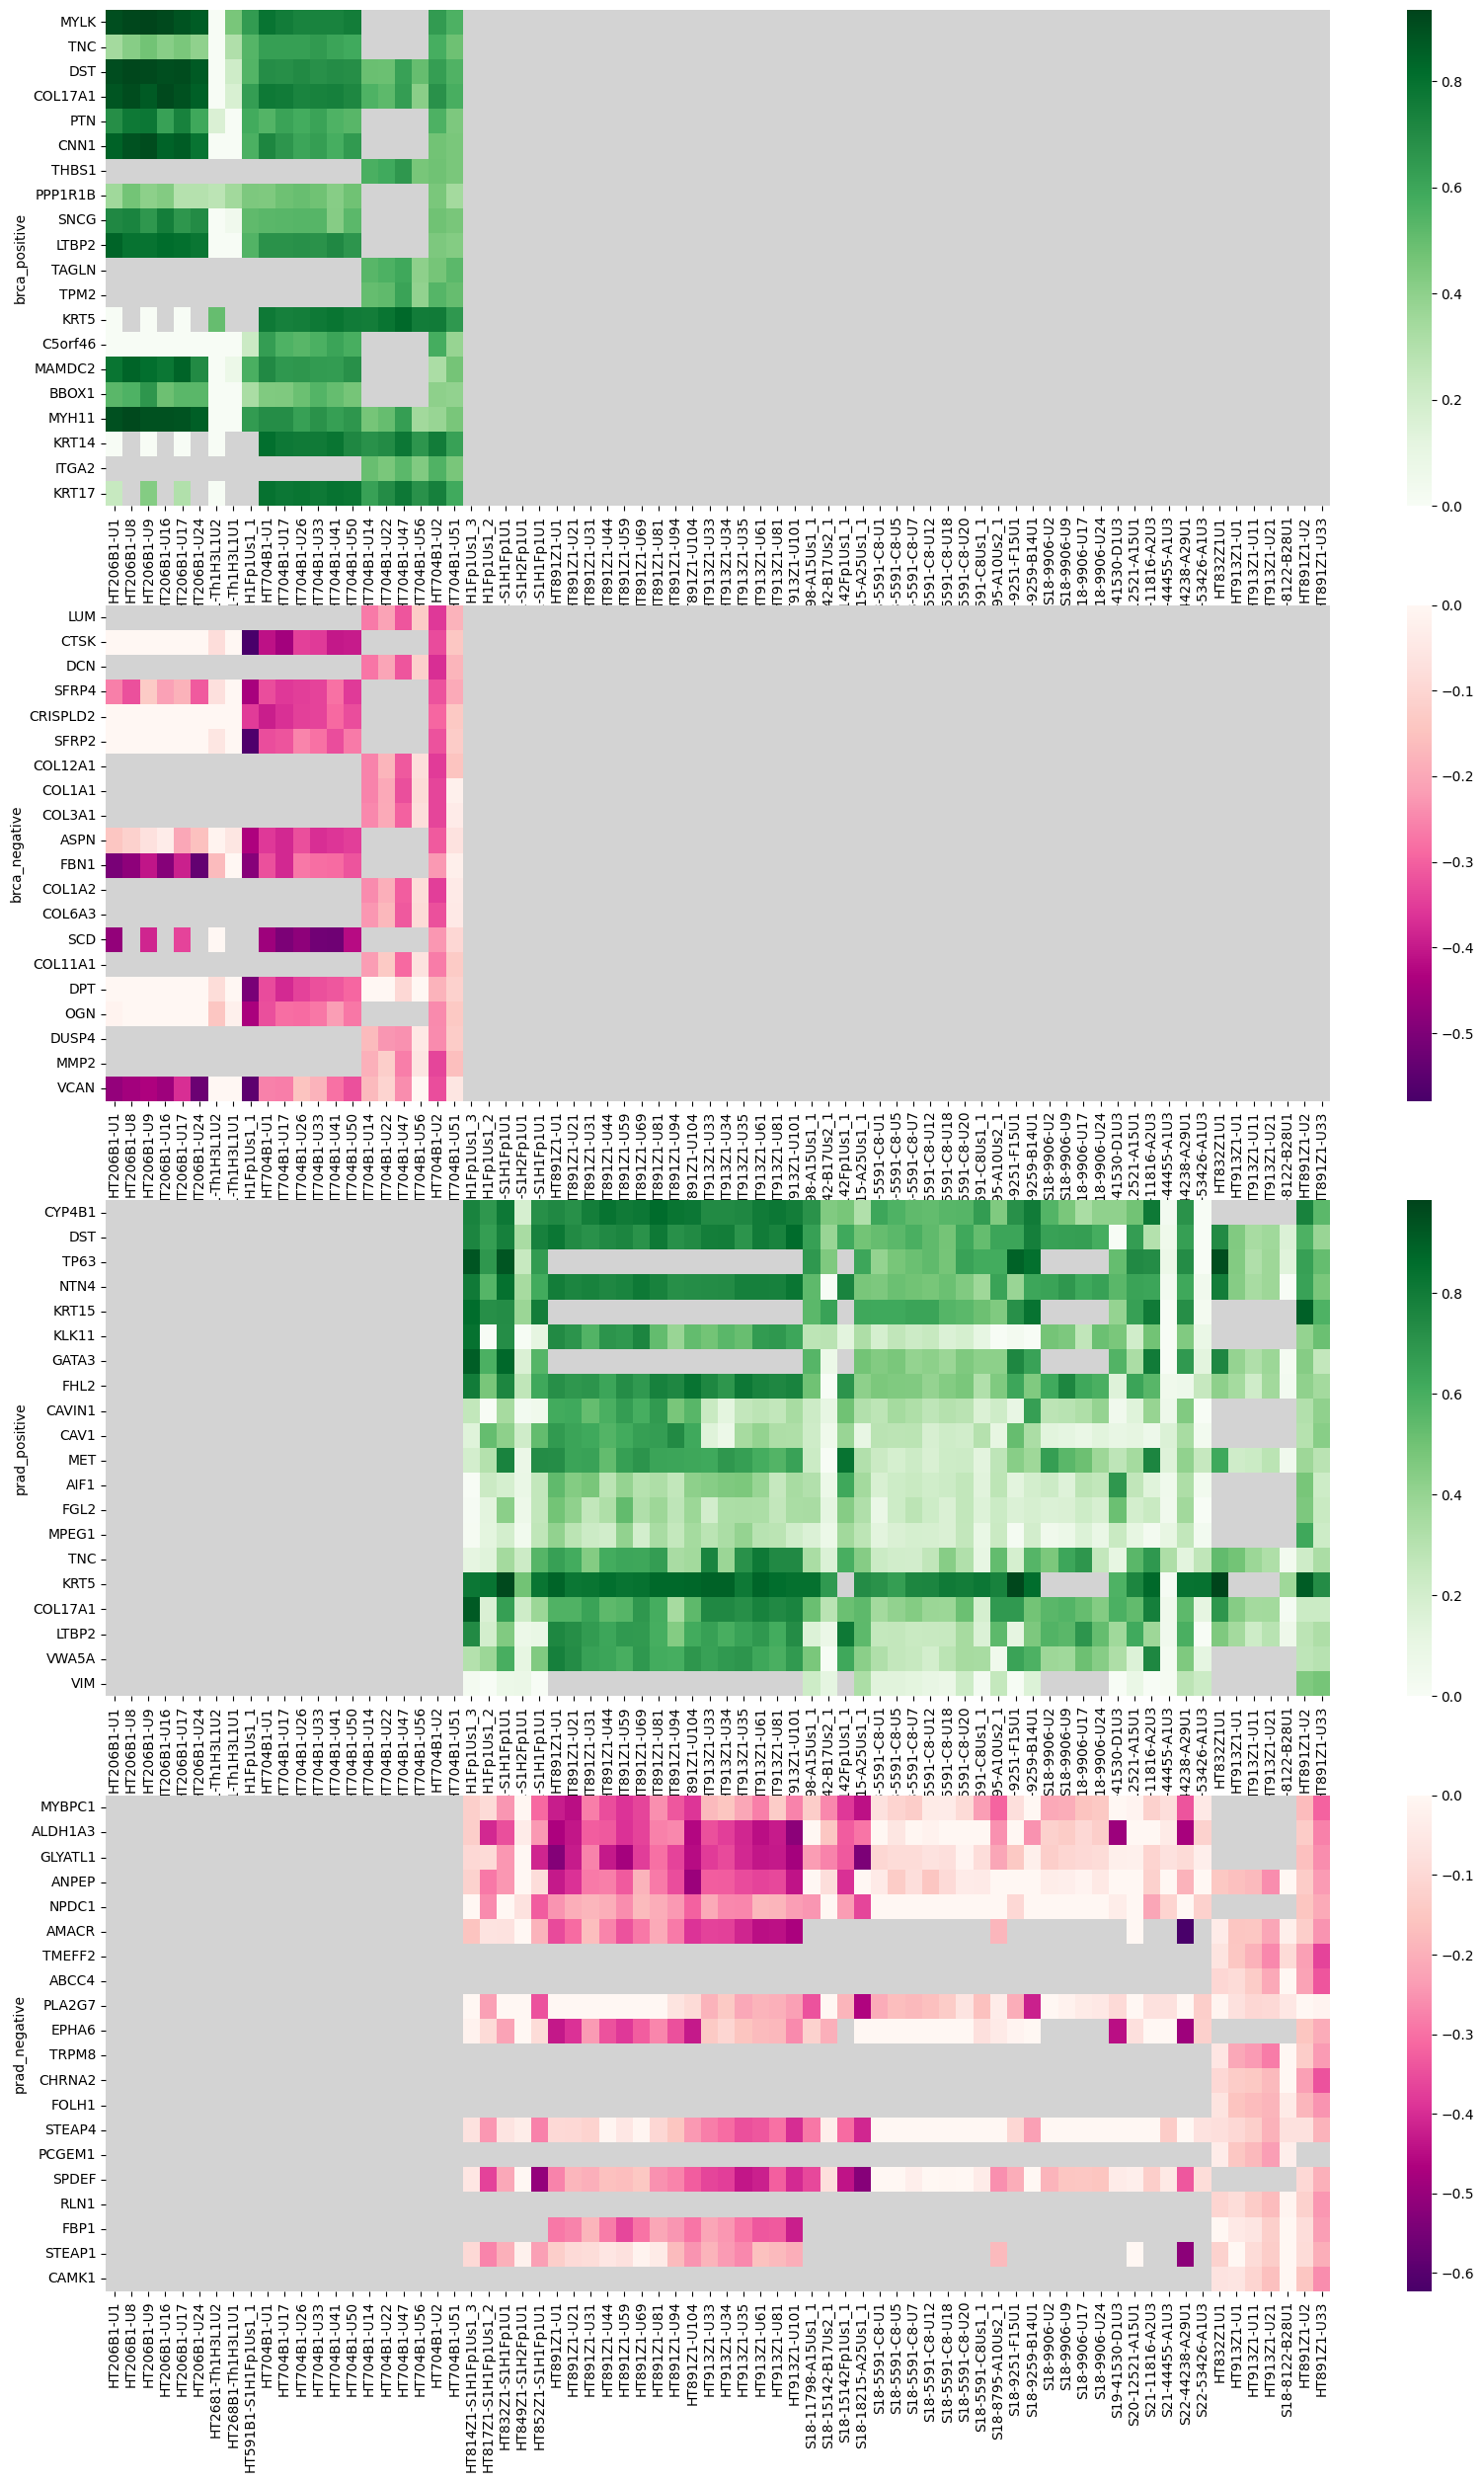

In [1034]:
fig, axs = plt.subplots(nrows=4, figsize=(20, 30))
i = 0
for disease, d1 in to_gene_consensus_corr_sources.items():
    for direction, source in d1.items():
        ax = axs[i]
        if direction == 'positive':
            X = source.values.copy()
            X[pd.isnull(X)] = 0
            vmin = 0
            vmax = X.max()
            cmap = 'Greens'
        else:
            X = source.values.copy()
            X[pd.isnull(X)] = 0
            vmin = X.min()
            vmax = 0
            cmap = 'RdPu_r'
        sns.heatmap(source, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
        ax.set_ylabel(f'{disease}_{direction}')
        ax.set_facecolor('lightgray')
        i += 1
plt.savefig(fig_dir / f'consensus_correlation_heatmaps.svg')

In [834]:
def get_consensus_twinned(direction):

    df1 = to_consensus['brca'][direction]
    df2 = to_consensus['prad'][direction]
    shared = sorted(set(df1['feature']).intersection(set(df2['feature'])))
    
    df1 = df1.set_index('feature')
    df2 = df2.set_index('feature')
    
    df1 = df1.loc[shared]
    df2 = df2.loc[shared]
    
    new = pd.DataFrame.from_dict({
        'feature': shared,
        'rank_pct_brca': df1['rank_pct'],
        'rank_pct_prad': df2['rank_pct'],
    })
    
    new = new[((new['rank_pct_brca'] < 1.) & (new['rank_pct_prad'] < 1.))]

    return new

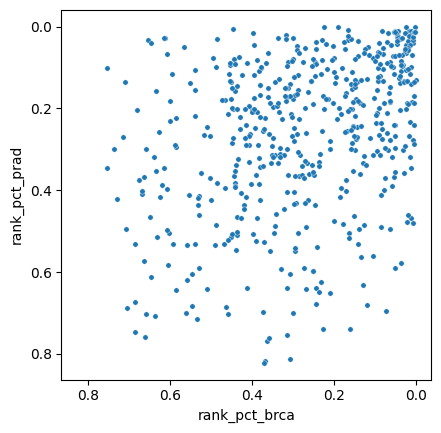

In [847]:
new = get_consensus_twinned('positive')

sns.scatterplot(data=new, x='rank_pct_brca', y='rank_pct_prad', s=15)
plt.axis('square')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.savefig(fig_dir / 'consensus_scatterplot_all_positive.svg')

In [848]:
f = new.copy()
f['score'] = (1 - f['rank_pct_brca']) * (1 - f['rank_pct_prad'])
f = f[f['rank_pct_brca'] < .05]
f = f[f['rank_pct_prad'] < .05]
for g in f.sort_values('score', ascending=False).index.to_list():
    print(g)

DST
TNC
COL17A1
KRT5
LTBP2
TP63
FGL2
CAVIN1
ITGB4
KRT17
GAS6
ITGB6
KRT14
EGFR
ITGA2
CAV1
GLIPR1
ITGA3
PLAT
VIM
CLCA2
MS4A6A
EHF
MGP
CX3CL1
NOTCH1
CFTR


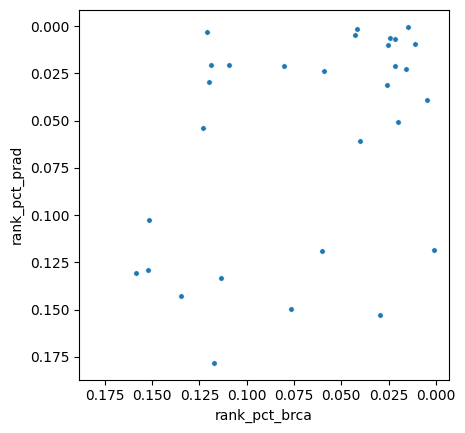

In [850]:
new = get_consensus_twinned('negative')

sns.scatterplot(data=new, x='rank_pct_brca', y='rank_pct_prad', s=15)
plt.axis('square')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.savefig(fig_dir / 'consensus_scatterplot_all_negative.svg')

In [851]:
f = new.copy()
f['score'] = (1 - f['rank_pct_brca']) * (1 - f['rank_pct_prad'])
f = f[f['rank_pct_brca'] < .05]
f = f[f['rank_pct_prad'] < .05]
for g in f.sort_values('score', ascending=False).index.to_list():
    print(g)

MYBPC1
FASN
STEAP1
FBP1
AR
CCDC78
ALCAM
GLYATL1
SCD
EPHA6
LDLR


In [852]:
corr_dfs.keys()

dict_keys(['brca_multiplex_region', 'brca_multiplex_boundary', 'brca_multiplex_tme', 'prad_multiplex_region', 'prad_multiplex_boundary', 'prad_multiplex_tme', 'brca_xenium_region', 'brca_xenium_boundary', 'brca_xenium_tme', 'prad_xenium_region', 'prad_xenium_boundary', 'prad_xenium_tme', 'brca_cosmx_region', 'brca_cosmx_boundary', 'brca_cosmx_tme', 'prad_cosmx_region', 'prad_cosmx_boundary', 'prad_cosmx_tme', 'brca_vishd_region', 'brca_vishd_boundary', 'brca_vishd_tme', 'prad_vishd_region', 'prad_vishd_boundary', 'prad_vishd_tme'])

In [853]:
f = None
v = None
disease_to_dtype_to_df = {}
for k, v in corr_dfs.items():
    disease, dtype, rtype = k.split('_')

    if rtype == 'region':
        exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
        idxs = [i for i in v.index.to_list() if not len([x for x in exclude if x in i])]
        f = v.loc[idxs]
        f = f[~pd.isnull(f['correlation'])]
        f.index = [x.replace('region_', '') for x in f.index.to_list()]

        if disease not in disease_to_dtype_to_df:
            disease_to_dtype_to_df[disease] = {}
        disease_to_dtype_to_df[disease][dtype] = f


In [854]:
disease_to_dtype_to_df['prad']['xenium']

,correlation,pvalue
KLK2,-0.361756,0.001115
KLK3,-0.304682,0.056221
NKX3-1,-0.251884,0.050322
AMACR,-0.242222,0.025868
GLYATL1,-0.229314,0.123626
...,...,...
NTN4,0.582711,0.058737
KRT15,0.584483,0.052422
DST,0.586606,0.024238
CYP4B1,0.621030,0.036254


In [855]:
dtype_to_df = {}
for dtype in ['xenium', 'vishd']:
    df1 = disease_to_dtype_to_df['brca'][dtype]
    df2 = disease_to_dtype_to_df['prad'][dtype]
    shared = sorted(set(df1.index.to_list()).intersection(set(df2.index.to_list())))
    
    df1 = df1.loc[shared]
    df2 = df2.loc[shared]
    
    new = pd.DataFrame.from_dict({
        'feature': shared,
        'corr_brca': df1['correlation'],
        'corr_prad': df2['correlation'],
    })
    
    dtype_to_df[dtype] = new


In [856]:
dtype_to_df['xenium']

,feature,corr_brca,corr_prad
ABCC11,ABCC11,-0.152185,0.006416
ACAN,ACAN,-0.084902,-0.028095
ACE2,ACE2,0.095140,0.126981
ACKR1,ACKR1,0.033729,0.026844
ACTA2,ACTA2,0.671197,0.040911
...,...,...,...
VIM,VIM,0.436127,0.098713
VPREB1,VPREB1,-0.026871,0.025934
VSIG4,VSIG4,0.157640,0.129583
VWA5A,VWA5A,0.464407,0.458400


In [985]:
gene_lists = {
    'brca_positive': [],
    'brca_negative': [],
    'prad_positive': [],
    'prad_negative': [],
    'combined_positive': [],
    'combined_negative': [],
}

(-0.519249379913608,
 0.8717922383557315,
 -0.41917477335196435,
 0.9718668449173751)

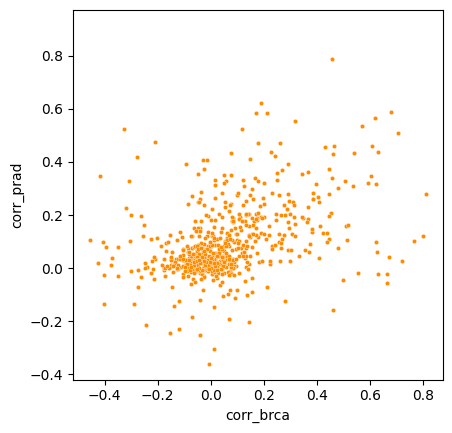

In [986]:
sns.scatterplot(data=dtype_to_df['xenium'], x='corr_brca', y='corr_prad', c='darkorange', s=10)
plt.axis('square')

In [987]:
f = dtype_to_df['xenium'].copy()
f['score'] = f['corr_brca'] * f['corr_prad']


In [988]:
x = f[f['corr_brca'] > .3]
x = x[x['corr_prad'] > .3]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_positive'] += genes
for g in genes: print(g)

DST
KRT5
COL17A1
TP63
KRT17
GATA3
LTBP2
MET
VWA5A
LAMC2
TNC
PLAT
PDPN
CAV1
KRT14
PTPRZ1
PCNX1
SAA1
PROM1
KITLG
GPX2
CAVIN1
CLCA2


In [989]:
x = f[f['corr_brca'] > .3]
x = x[x['corr_prad'] < .1]
genes = x.sort_values('corr_prad', ascending=True).index.to_list()
gene_lists['brca_positive'] += genes
for g in genes: print(g)

TMPRSS2
MYH11
SLC39A6
SREBF1
CNN1
PTN
MYLK
PPP1R1B
ACTA2
MMRN2
MAMDC2
ERG
TFPI
MBP
PDGFRA
SMAD4
MUC1
VIM


In [990]:
x = f[f['corr_brca'] < .1]
x = x[x['corr_prad'] > .3]
genes = x.sort_values('corr_brca', ascending=True).index.to_list()
gene_lists['prad_positive'] += genes
for g in genes: print(g)

GPRC5A
KRT19
LYPD3
IRAK3
KRT7
SOX2
MDM2
CD74
KLK11
AMY2B
AQP3
CLIC6
EDN1
SYPL1
CFTR
S100P
CCL2


In [991]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_negative'] += genes
for g in genes: print(g)

SCD
FBP1
STEAP1
AMACR
GLYATL1
EPHA6
ONECUT2


In [992]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] > .1]
genes = x.sort_values('corr_prad', ascending=False).index.to_list()
gene_lists['brca_negative'] += genes
for g in genes: print(g)

KRT19
KRT7
IRAK3
GPRC5A
LYPD3
PCNA
KRT8
S100A4
TLE4
KLRC1
KRT18
AZGP1
CCND1
VEGFA
ENPP3
ATP6V1C1
CTSK
VCAN


In [993]:
x = f[f['corr_brca'] > .1]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('corr_brca', ascending=False).index.to_list()
gene_lists['prad_negative'] += genes
for g in genes: print(g)

TMPRSS2
ANPEP
ALDH1A3
GPR160


(-0.3605374590230666,
 0.8735457386247649,
 -0.355729380432333,
 0.8783538172154985)

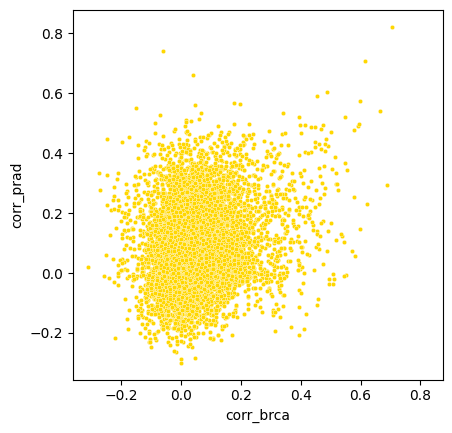

In [994]:
sns.scatterplot(data=dtype_to_df['vishd'], x='corr_brca', y='corr_prad', c='gold', s=10)
plt.axis('square')

In [995]:
f = dtype_to_df['vishd'].copy()
f['score'] = f['corr_brca'] * f['corr_prad']

In [996]:
x = f[f['corr_brca'] > .4]
x = x[x['corr_prad'] > .4]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_positive'] += genes
for g in genes: print(g)

KRT5
TRIM29
KRT17
LAMB3
ITGB4
GSTP1
DST
DSC3
WFDC2
TP63
ITGA2
ANXA1
TNS4
OBSCN
ITGB8
SLPI
A2M
F3
S100A6
COL7A1
EFNA5
ITGB6
TINAGL1
ITGA3
PERP
DEFB1
SCPEP1
PIK3R1


In [997]:
x = f[f['corr_brca'] > .4]
x = x[x['corr_prad'] < .1]
genes = x.sort_values('corr_prad', ascending=True).index.to_list()
gene_lists['brca_positive'] += genes
for g in genes: print(g)

ANPEP
IRX2
IRX4
FAM20C
NFIX
CCDC9B
MIA
ELF5
PHGDH
KLK5
KRT6B
IRX1
SOX10
KLK7
GUCY1A1
SBSPON
C5orf46
CHI3L1
KCNMB1
PPP1R14C
RASSF10
NFIB
SYNM
CNN1
ECRG4
LAD1
ACTG2
SLC34A2


In [998]:
x = f[f['corr_brca'] < .1]
x = x[x['corr_prad'] > .4]
genes = x.sort_values('corr_brca', ascending=True).index.to_list()
gene_lists['prad_positive'] += genes
for g in genes: print(g)

SERPINF1
C3
RHOB
GJA1
DDIT4
TSC22D3
STOM
CHPT1
XG
APOL1
GLUL
RUNX1
THSD4
BHLHE40
WIPF1
KRT19
KRT15
GPX3
SORL1
CYP4X1
IRX3
SLC2A5
GBP4
ID1
LIPC
SELENOM
EPAS1
APOBR
HOXD10
AVPI1
C1R
SLFN12
NCKAP1L
IFITM3
WNT3A
GRASP
EPB41L2
XAF1
ZFP36L1
TRIB2
CPA6
TMSB4X
UCP2
ANXA2
APOL4
CSF2RA
HOXD11
APOL5
MUC4
CYP3A5
SIRPB2
LGALS3
CYP4B1
RASAL3
SPTLC3
MFSD4A
NTN4
ARRDC2
DBNDD2
RASSF4
CLDN1
CD74
PDK4
HEXA
ZEB2
ARHGEF19
DUOX2
INKA1
ENPP2
TMEM173
KLK11
CD4
S1PR5


In [999]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('score', ascending=False).index.to_list()
gene_lists['combined_negative'] += genes
for g in genes: print(g)

NPNT
FASN
CPNE7
CNTNAP2
MLPH
HID1
TPD52
INPP4B
EEF1A2
ABAT
TP53INP1
GREB1
NPR3
KLK4
ARHGEF38
PYCR1
FOXA1
CRAT
SPDEF
MAPK8IP2
FAM110B
MCCC2
NTNG2
ALCAM
AR
GSE1
STEAP4
PRRT2
PRLR
TRPM4
ABLIM3
ERGIC1


In [1000]:
x = f[f['corr_brca'] < -.1]
x = x[x['corr_prad'] > .2]
genes = x.sort_values('corr_prad', ascending=False).index.to_list()
gene_lists['brca_negative'] += genes
for g in genes: print(g)

GJA1
RHOB
SERPINF1
CHPT1
C3
XG
DDIT4
STOM
TSC22D3
CYBRD1
KRT23
TCIM
TIMP2
PREX1
TIMP3
DCN
LPAR5
VWA2
MMP2
PRSS23
FN1
PRRX1
CRISPLD2
LRP1
CCDC3
MAP3K1
SPTSSB
DUSP4
HTRA1
ARHGAP40
TMEM119
SFRP2
LUM
C1S
KLF2
EFHD1
LTBP1
VCAM1
TGFB3
SPARC
MS4A7
PGR
GSTM3
ASPH
SERPINA11
AEBP1
FBLN1
CCN4
COL14A1
FGD3
IGFBP4
COL6A3
SLC38A1
NBL1
RAB31
IGF1
GPRC5A
EMP2
SPON1
CTSK
RASGRF2
CCDC80
ELN
MAN1A1
ETNK2
COL1A2
COL3A1


In [1001]:
x = f[f['corr_brca'] > .2]
x = x[x['corr_prad'] < -.1]
genes = x.sort_values('corr_brca', ascending=False).index.to_list()
gene_lists['prad_negative'] += genes
for g in genes: print(g)

IRX4
IRX2
ANPEP
PPP1R1B
LGR4
DLGAP1
IRS2
LARGE2
C1orf116
AMOTL1
TMPRSS2
TUSC3
SPTBN2
PLEKHB1
SLC25A37
LRATD1
BICD1
MESP1
ZNF462
RASSF3
MSI1


In [1002]:
for disease, d1 in to_gene_corr_sources.items():
    for dti, d2 in d1.items():
        for direction, f in d2.items():
            key = f'{disease}_{direction}'
            gene_lists[key] += f.index.to_list()

for k, v in gene_lists.items():
    print(k, len(set(v)))

for disease, d1 in to_gene_consensus_corr_sources.items():
    for direction, f in d1.items():
        key = f'{disease}_{direction}'
        gene_lists[key] += f.index.to_list()

for k, v in gene_lists.items():
    print(k, len(set(v)))

diseases = ['brca', 'prad']
dtypes = ['xenium', 'cosmx', 'vishd']
idents = ['region', 'tme']
exclude = ['celltypes', 'nbhd', 'myoepithelial', 'epithelial']
tups = [(ident, dtype) for ident in idents for dtype in dtypes]
for i, disease in enumerate(diseases):
    for j, dtype in enumerate(dtypes):
        for k, ident in enumerate(idents):
            df = corr_dfs[f'{disease}_{dtype}_{ident}']
            idxs = [i for i in df.index.to_list() if not len([x for x in exclude if x in i])]
            source = df.loc[idxs]
            source = source[~pd.isnull(source['correlation'])]
            if source.shape[0]:
                if n * 2 < source.shape[0]:
                    source = pd.concat((source.iloc[:n], source.iloc[-n:]))
                source = source.sort_values('correlation', ascending=False)
                source.index = [c.replace(f'region_', '').replace('tme_', '') for c in source.index.to_list()]

                for feat, corr in zip(source.index.to_list(), source['correlation']):
                    if corr > 0:
                        gene_lists[f'{disease}_positive'].append(feat)
                    else:
                        gene_lists[f'{disease}_negative'].append(feat)

for k, v in gene_lists.items():
    print(k, len(set(v)))

brca_positive 102
brca_negative 119
prad_positive 143
prad_negative 75
combined_positive 47
combined_negative 39
brca_positive 104
brca_negative 121
prad_positive 153
prad_negative 78
combined_positive 47
combined_negative 39
brca_positive 129
brca_negative 142
prad_positive 163
prad_negative 89
combined_positive 47
combined_negative 39


In [1003]:

a = set(gene_lists['brca_positive'])
b = set(gene_lists['prad_positive'])
common = a.intersection(b)

a -= common
b -= common
c = set(gene_lists['combined_positive'])
d = set.union(common, c)

gene_lists['brca_positive'] = sorted(a)
gene_lists['prad_positive'] = sorted(b)
gene_lists['combined_positive'] = sorted(d)

a = set(gene_lists['brca_negative'])
b = set(gene_lists['prad_negative'])
common = a.intersection(b)

a -= common
b -= common
c = set(gene_lists['combined_negative'])
d = set.union(common, c)

gene_lists['brca_negative'] = sorted(a)
gene_lists['prad_negative'] = sorted(b)
gene_lists['combined_negative'] = sorted(d)

for k, v in gene_lists.items():
    print(k, len(set(v)))

brca_positive 98
brca_negative 139
prad_positive 132
prad_negative 86
combined_positive 60
combined_negative 39


{'brca_positive': ['ACTA2',
  'ACTG2',
  'ANPEP',
  'ANXA1',
  'APP',
  'ARFGEF3',
  'BBOX1',
  'C5orf46',
  'CALD1',
  'CALML3',
  'CCDC9B',
  'CDH1',
  'CDH3',
  'CHI3L1',
  'CNN1',
  'CRYAB',
  'DSG3',
  'ECRG4',
  'ELF5',
  'ERG',
  'FAM20C',
  'FBLN1',
  'GAS6',
  'GUCY1A1',
  'IFFO2',
  'IFI44L',
  'IRX1',
  'IRX2',
  'IRX4',
  'ITGA2',
  'ITGA3',
  'JUN',
  'KCNMB1',
  'KITLG',
  'KLK5',
  'KLK7',
  'KRT6A/B/C',
  'KRT6B',
  'LAD1',
  'LAMC2',
  'LEPR',
  'MAMDC2',
  'MBP',
  'MGP',
  'MIA',
  'MMP7',
  'MMRN2',
  'MUC1',
  'MYH11',
  'MYL9',
  'MYLK',
  'NFIB',
  'NFIX',
  'NGFR',
  'NTRK2',
  'PDGFRA',
  'PDLIM4',
  'PHGDH',
  'PLAT',
  'PPP1R14C',
  'PPP1R1B',
  'PTN',
  'RASSF10',
  'S100A2',
  'SAA1/2',
  'SBSPON',
  'SCNN1A',
  'SFN',
  'SLC34A2',
  'SLC39A6',
  'SMAD4',
  'SNCG',
  'SOX10',
  'SREBF1',
  'STC2',
  'SYNM',
  'SYT8',
  'TACSTD2',
  'TAGLN',
  'TBX18',
  'TCIM',
  'TFPI',
  'THBS1',
  'TINAGL1',
  'TM4SF18',
  'TMPRSS2',
  'TPM2',
  'WFDC2',
  'cd11b',
  'ck

In [1006]:
for k, vs in gene_lists.items():
    for v in vs:
        print(f'{k}\t{v}')

brca_positive	ACTA2
brca_positive	ACTG2
brca_positive	ANPEP
brca_positive	ANXA1
brca_positive	APP
brca_positive	ARFGEF3
brca_positive	BBOX1
brca_positive	C5orf46
brca_positive	CALD1
brca_positive	CALML3
brca_positive	CCDC9B
brca_positive	CDH1
brca_positive	CDH3
brca_positive	CHI3L1
brca_positive	CNN1
brca_positive	CRYAB
brca_positive	DSG3
brca_positive	ECRG4
brca_positive	ELF5
brca_positive	ERG
brca_positive	FAM20C
brca_positive	FBLN1
brca_positive	GAS6
brca_positive	GUCY1A1
brca_positive	IFFO2
brca_positive	IFI44L
brca_positive	IRX1
brca_positive	IRX2
brca_positive	IRX4
brca_positive	ITGA2
brca_positive	ITGA3
brca_positive	JUN
brca_positive	KCNMB1
brca_positive	KITLG
brca_positive	KLK5
brca_positive	KLK7
brca_positive	KRT6A/B/C
brca_positive	KRT6B
brca_positive	LAD1
brca_positive	LAMC2
brca_positive	LEPR
brca_positive	MAMDC2
brca_positive	MBP
brca_positive	MGP
brca_positive	MIA
brca_positive	MMP7
brca_positive	MMRN2
brca_positive	MUC1
brca_positive	MYH11
brca_positive	MYL9
brca_positi